# Train Encoder for CMP_code classification

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp drive/MyDrive/BSC/tfm/encoder/lib/utils.py .

Mounted at /content/drive


In [2]:
%%capture
!pip install transformers

In [3]:
from utils import *

from random import *
import os
import argparse
import sys
import pandas as pd
import torch
import numpy as np

from transformers import BertTokenizer
from torch import nn
from torch.optim import Adam
from sklearn.metrics import f1_score
from tqdm import tqdm

## Functions

In [4]:
def train(model: BertClassifier, tokenizer:BertTokenizer, labels_dict:dict, train_data:pd.DataFrame, val_data:pd.DataFrame, epochs:int, criterion, optimizer, bs:int=2, patience=5):
    """
    Function to train the 'model' for a number of epochs and evaluate it with 'val_data'
    @param model: the model to train, the classifier.
    @param tokenizer: the Tokenizer used to tokenize the sentences
    @param labels_dict: a dictionary relting the original labels with the codification
    @param train_data: the dataframe containing the training data
    @param val_data: the dataframe contining the validation data
    @param epochs: the number of epochs to train the model for
    @param criterion: the loss used to train the model
    @param optimizer: the optimizer used to train the model
    @param bs: the batch size used to train the model
    return: the train and validaton accuracy and losses per epoch
    """
    # Generate the DataLoaders for Training and Validation
    train_dataloader = torch.utils.data.DataLoader(Dataset(train_data, tokenizer, labels_dict), batch_size=bs, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(Dataset(val_data, tokenizer, labels_dict), batch_size=bs)
    total_labels = list(labels_dict.values())

    # Move to corresponding device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # Placeholders for storing metric evolution
    train_acc, train_loss, train_f1, train_f1_macro = [],[],[],[]
    val_acc, val_loss, val_f1, val_f1_macro = [],[],[],[]

    best_loss=np.inf
    patience_counter = 0

    # For every epoch
    for epoch_num in range(epochs):
        print(f"Epoch {epoch_num+1}/{epochs}")

        total_acc_train, total_loss_train = 0, 0
        total_acc_val, total_loss_val = 0, 0

        targets = []
        outputs = []

        ##### TRAIN #####
        # For every batch in the Dataloader
        for train_input, train_label in tqdm(train_dataloader):
            # Obtain inputs and move them to corresponding device
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            # Forward pass
            output = model(input_id, mask)

            # Accuracy and Loss computation
            pred_label = output.argmax(dim=1)
            outputs.extend(pred_label.detach().cpu().numpy())
            targets.extend(train_label.detach().cpu().numpy())

            acc = (pred_label == train_label).sum().item()
            total_acc_train += acc

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        train_f1_macro.append(f1_score(outputs, targets, average='macro', labels=total_labels, zero_division=0))
        train_acc.append(total_acc_train / len(train_data))
        train_loss.append(total_loss_train / len(train_data))

        targets = []
        outputs = []
        with torch.no_grad():
            ##### VALIDATE #####
            # For every batch in the Dataloader
            for val_input, val_label in val_dataloader:
                # Obtain inputs and move them to corresponding device
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                # Forward pass
                output = model(input_id, mask)

                # Accuracy and Loss computation
                pred_label = output.argmax(dim=1)
                outputs.extend(pred_label.detach().cpu().numpy())
                targets.extend(val_label.detach().cpu().numpy())
                acc = (pred_label == val_label).sum().item()
                total_acc_val += acc
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

        val_f1_macro.append(f1_score(outputs, targets, average='macro', labels=total_labels, zero_division=0))
        val_acc.append(total_acc_val / len(val_data))
        val_loss.append(total_loss_val / len(val_data))

        print(f'Epoch: {epoch_num + 1} '+
            f'| Train Loss: {train_loss[epoch_num]: .3f} | Train Accuracy: {train_acc[epoch_num]: .3f} | Train F1 (macro): {train_f1_macro[epoch_num]: .3f}'+
            f'| Val Loss: {val_loss[epoch_num]: .3f} | Val Accuracy: {val_acc[epoch_num]: .3f} | Val F1 (macro): {val_f1_macro[epoch_num]: .3f}')

        if val_loss[epoch_num] < best_loss:
            best_loss = val_loss[epoch_num]
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"[WARNING] Exitting because patience ({patience}) on loss has been reached")
            break


    return np.asarray(train_acc), np.asarray(train_loss), np.asarray(train_f1_macro), np.asarray(val_acc), np.asarray(val_loss), np.asarray(val_f1_macro)


def evaluate(model: BertClassifier, tokenizer:BertTokenizer, labels_dict:dict, test_data:pd.DataFrame):
    """
    Function to evaluate the 'model' with 'test_data'
    @param model: the model to train, the classifier.
    @param tokenizer: the Tokenizer used to tokenize the sentences
    @param labels_dict: a dictionary relting the original labels with the codification
    @param test_data: the dataframe containing the data to test
    return: nothing
    """
    # Generate the DataLoader for the Testing DF
    test_dataloader = torch.utils.data.DataLoader(Dataset(test_data, tokenizer, labels_dict), batch_size=2)
    total_labels = list(labels_dict.values())

    # Move to corresponding device
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    total_acc_test = 0

    targets = []
    outputs = []
    with torch.no_grad():
        # For every batch in the Dataloader
        for test_input, test_label in test_dataloader:
            # Obtain inputs and move them to corresponding device
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            # Forward pass
            output = model(input_id, mask)

            # Accuracy computation
            pred_label = output.argmax(dim=1)
            outputs.extend(pred_label.detach().cpu().numpy())
            targets.extend(test_label.detach().cpu().numpy())
            acc = (pred_label == test_label).sum().item()
            total_acc_test += acc

    test_f1_macro = f1_score(outputs, targets, average='macro', labels=total_labels, zero_division=0)
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f} | Test F1 Score (macro): {test_f1_macro: .3f}')

In [5]:
data_path = "/content/drive/MyDrive/BSC/tfm/encoder/dataset/english"
train_file_name = "CMPDa20_c2_train.xlsx"
tokenizer_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer_name = "bert-base-cased"
save_model_path = "/content/drive/MyDrive/BSC/tfm/encoder/results/torchmodel_weights.pth"
epochs = 50
lr = 1e-5
bs = 8
reduced = False
reduced_size = 20000
results_path = "/content/drive/MyDrive/BSC/tfm/encoder/results/"
print_graphs = True

# Obtain dataframe containing sentences and labels; and compute the number of classes
train_path = os.path.join(data_path, train_file_name)
val_path = os.path.join(data_path, "CMPD_val.xlsx")
test_path = os.path.join(data_path, "CMPD_test.xlsx")
train_df, val_df, test_df = read_data(train_path, level_codes=1), read_data(val_path, level_codes=1), read_data(test_path, level_codes=1)
all_orig_labels = sorted(np.unique(list(train_df["cmp_code"])))
num_classes = len(all_orig_labels)
labels_dict = {f'{code}':i for i,code in enumerate(all_orig_labels)}

# Create tokenizer and model
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
model = BertClassifier(tokenizer_name = tokenizer_name, num_classes = num_classes)

# Define hyperparameters of the training
EPOCHS = epochs
LR = lr
BS = bs
BS_VAL = 8
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= LR)

# Split the dataset into training, validation and testing
np.random.seed(112)
if reduced:
    n_samples_train = len(train_df) if reduced_size > len(train_df) else reduced_size
    per = n_samples_train / len(train_df)
    n_samples_val, n_samples_test = int(len(val_df)*per), int(len(test_df)*per)
    train_data = train_df.iloc[0:n_samples_train]
    val_data = val_df.iloc[0:n_samples_val]
    test_data = test_df.iloc[0:n_samples_test]
else:
    train_data = train_df
    val_data = val_df
    test_data = test_df
print("Sizes of the target train, validation and test datasets:", len(train_data),len(val_data), len(test_data))

##### TRAIN #####
train_acc, train_loss, train_f1, val_acc, val_loss, val_f1 = train(model, tokenizer, labels_dict, train_data, val_data, EPOCHS, loss_fn, optimizer, BS)

##### EVALUATE #####
evaluate(model,tokenizer, labels_dict, test_data)


Loading the data...
Loading the data...
Loading the data...


Sizes of the target train, validation and test datasets: 25539 5897 2929
Epoch 1/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 1 | Train Loss:  0.482 | Train Accuracy:  0.207 | Train F1 (macro):  0.019| Val Loss:  0.480 | Val Accuracy:  0.221 | Val F1 (macro):  0.021
Epoch 2/50


100%|██████████| 3193/3193 [12:14<00:00,  4.35it/s]


Epoch: 2 | Train Loss:  0.474 | Train Accuracy:  0.265 | Train F1 (macro):  0.030| Val Loss:  0.472 | Val Accuracy:  0.284 | Val F1 (macro):  0.037
Epoch 3/50


100%|██████████| 3193/3193 [12:14<00:00,  4.35it/s]


Epoch: 3 | Train Loss:  0.467 | Train Accuracy:  0.325 | Train F1 (macro):  0.047| Val Loss:  0.470 | Val Accuracy:  0.301 | Val F1 (macro):  0.047
Epoch 4/50


100%|██████████| 3193/3193 [12:16<00:00,  4.33it/s]


Epoch: 4 | Train Loss:  0.464 | Train Accuracy:  0.344 | Train F1 (macro):  0.057| Val Loss:  0.466 | Val Accuracy:  0.338 | Val F1 (macro):  0.064
Epoch 5/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 5 | Train Loss:  0.455 | Train Accuracy:  0.425 | Train F1 (macro):  0.097| Val Loss:  0.459 | Val Accuracy:  0.392 | Val F1 (macro):  0.095
Epoch 6/50


100%|██████████| 3193/3193 [12:14<00:00,  4.35it/s]


Epoch: 6 | Train Loss:  0.450 | Train Accuracy:  0.462 | Train F1 (macro):  0.110| Val Loss:  0.458 | Val Accuracy:  0.396 | Val F1 (macro):  0.100
Epoch 7/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 7 | Train Loss:  0.446 | Train Accuracy:  0.487 | Train F1 (macro):  0.123| Val Loss:  0.456 | Val Accuracy:  0.409 | Val F1 (macro):  0.107
Epoch 8/50


100%|██████████| 3193/3193 [12:16<00:00,  4.34it/s]


Epoch: 8 | Train Loss:  0.445 | Train Accuracy:  0.497 | Train F1 (macro):  0.127| Val Loss:  0.455 | Val Accuracy:  0.417 | Val F1 (macro):  0.106
Epoch 9/50


100%|██████████| 3193/3193 [12:16<00:00,  4.33it/s]


Epoch: 9 | Train Loss:  0.443 | Train Accuracy:  0.516 | Train F1 (macro):  0.141| Val Loss:  0.455 | Val Accuracy:  0.424 | Val F1 (macro):  0.121
Epoch 10/50


100%|██████████| 3193/3193 [12:16<00:00,  4.34it/s]


Epoch: 10 | Train Loss:  0.440 | Train Accuracy:  0.538 | Train F1 (macro):  0.157| Val Loss:  0.451 | Val Accuracy:  0.454 | Val F1 (macro):  0.137
Epoch 11/50


100%|██████████| 3193/3193 [12:16<00:00,  4.33it/s]


Epoch: 11 | Train Loss:  0.436 | Train Accuracy:  0.572 | Train F1 (macro):  0.178| Val Loss:  0.451 | Val Accuracy:  0.451 | Val F1 (macro):  0.147
Epoch 12/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 12 | Train Loss:  0.434 | Train Accuracy:  0.587 | Train F1 (macro):  0.186| Val Loss:  0.449 | Val Accuracy:  0.468 | Val F1 (macro):  0.151
Epoch 13/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 13 | Train Loss:  0.432 | Train Accuracy:  0.599 | Train F1 (macro):  0.195| Val Loss:  0.448 | Val Accuracy:  0.476 | Val F1 (macro):  0.154
Epoch 14/50


100%|██████████| 3193/3193 [12:16<00:00,  4.34it/s]


Epoch: 14 | Train Loss:  0.431 | Train Accuracy:  0.612 | Train F1 (macro):  0.204| Val Loss:  0.448 | Val Accuracy:  0.474 | Val F1 (macro):  0.157
Epoch 15/50


100%|██████████| 3193/3193 [12:16<00:00,  4.34it/s]


Epoch: 15 | Train Loss:  0.430 | Train Accuracy:  0.617 | Train F1 (macro):  0.206| Val Loss:  0.449 | Val Accuracy:  0.472 | Val F1 (macro):  0.154
Epoch 16/50


100%|██████████| 3193/3193 [12:16<00:00,  4.34it/s]


Epoch: 16 | Train Loss:  0.429 | Train Accuracy:  0.626 | Train F1 (macro):  0.209| Val Loss:  0.448 | Val Accuracy:  0.473 | Val F1 (macro):  0.156
Epoch 17/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 17 | Train Loss:  0.428 | Train Accuracy:  0.630 | Train F1 (macro):  0.214| Val Loss:  0.448 | Val Accuracy:  0.479 | Val F1 (macro):  0.164
Epoch 18/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 18 | Train Loss:  0.426 | Train Accuracy:  0.645 | Train F1 (macro):  0.228| Val Loss:  0.448 | Val Accuracy:  0.479 | Val F1 (macro):  0.165
Epoch 19/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 19 | Train Loss:  0.427 | Train Accuracy:  0.642 | Train F1 (macro):  0.227| Val Loss:  0.447 | Val Accuracy:  0.481 | Val F1 (macro):  0.163
Epoch 20/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 20 | Train Loss:  0.426 | Train Accuracy:  0.651 | Train F1 (macro):  0.233| Val Loss:  0.447 | Val Accuracy:  0.484 | Val F1 (macro):  0.171
Epoch 21/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 21 | Train Loss:  0.424 | Train Accuracy:  0.662 | Train F1 (macro):  0.245| Val Loss:  0.447 | Val Accuracy:  0.485 | Val F1 (macro):  0.174
Epoch 22/50


100%|██████████| 3193/3193 [12:16<00:00,  4.34it/s]


Epoch: 22 | Train Loss:  0.424 | Train Accuracy:  0.667 | Train F1 (macro):  0.248| Val Loss:  0.447 | Val Accuracy:  0.488 | Val F1 (macro):  0.177
Epoch 23/50


100%|██████████| 3193/3193 [12:18<00:00,  4.32it/s]


Epoch: 23 | Train Loss:  0.424 | Train Accuracy:  0.668 | Train F1 (macro):  0.250| Val Loss:  0.448 | Val Accuracy:  0.479 | Val F1 (macro):  0.175
Epoch 24/50


100%|██████████| 3193/3193 [12:17<00:00,  4.33it/s]


Epoch: 24 | Train Loss:  0.423 | Train Accuracy:  0.672 | Train F1 (macro):  0.251| Val Loss:  0.447 | Val Accuracy:  0.485 | Val F1 (macro):  0.175
Epoch 25/50


100%|██████████| 3193/3193 [12:18<00:00,  4.32it/s]


Epoch: 25 | Train Loss:  0.423 | Train Accuracy:  0.675 | Train F1 (macro):  0.253| Val Loss:  0.447 | Val Accuracy:  0.486 | Val F1 (macro):  0.177
Epoch 26/50


100%|██████████| 3193/3193 [12:17<00:00,  4.33it/s]


Epoch: 26 | Train Loss:  0.422 | Train Accuracy:  0.677 | Train F1 (macro):  0.255| Val Loss:  0.448 | Val Accuracy:  0.478 | Val F1 (macro):  0.175
Epoch 27/50


100%|██████████| 3193/3193 [12:15<00:00,  4.34it/s]


Epoch: 27 | Train Loss:  0.422 | Train Accuracy:  0.677 | Train F1 (macro):  0.256| Val Loss:  0.448 | Val Accuracy:  0.479 | Val F1 (macro):  0.171
[WARNING] Exitting because patience (5) on loss has been reached
Test Accuracy:  0.494 | Test F1 Score (macro):  0.176


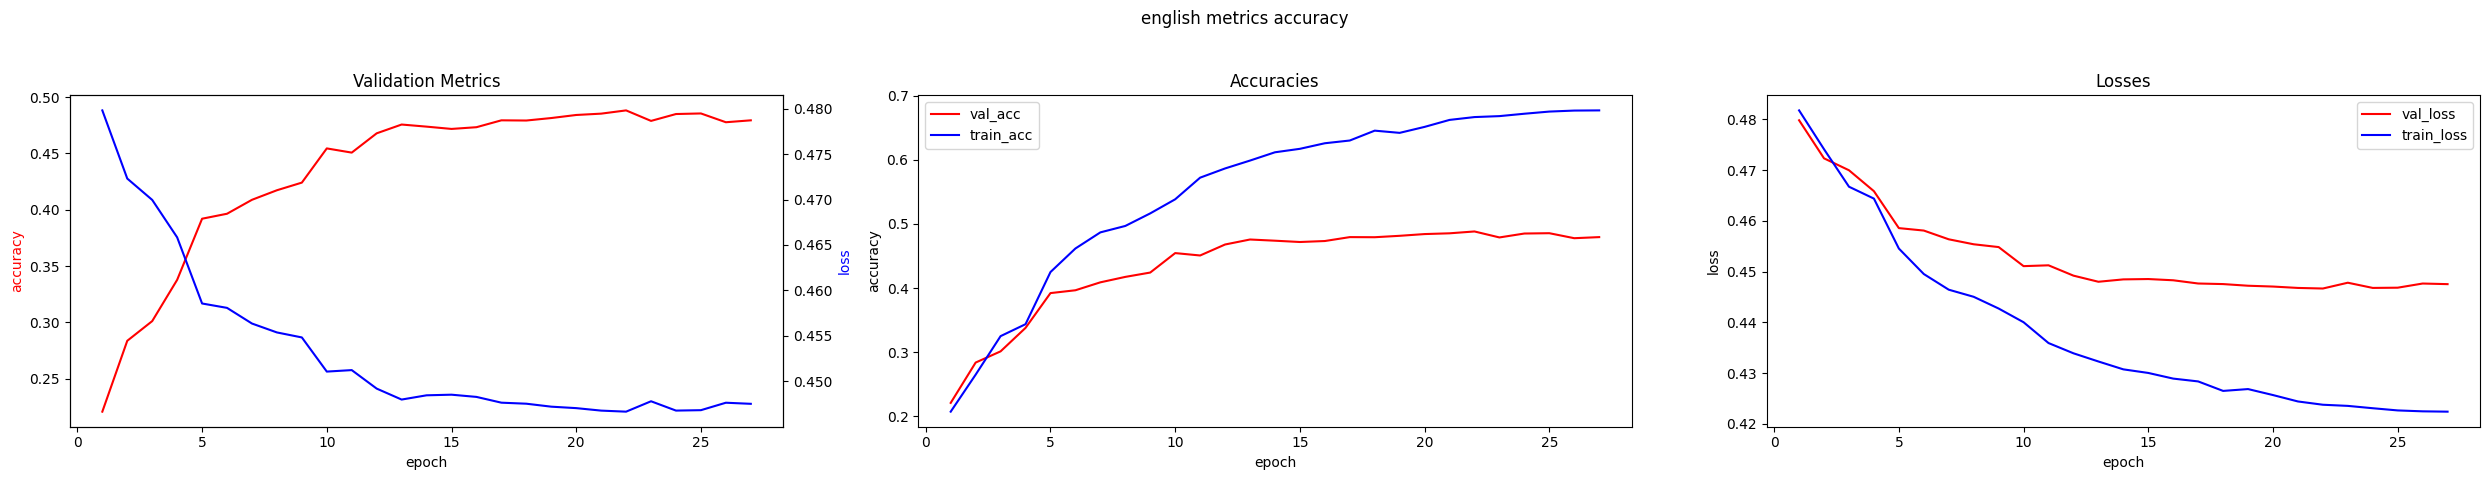

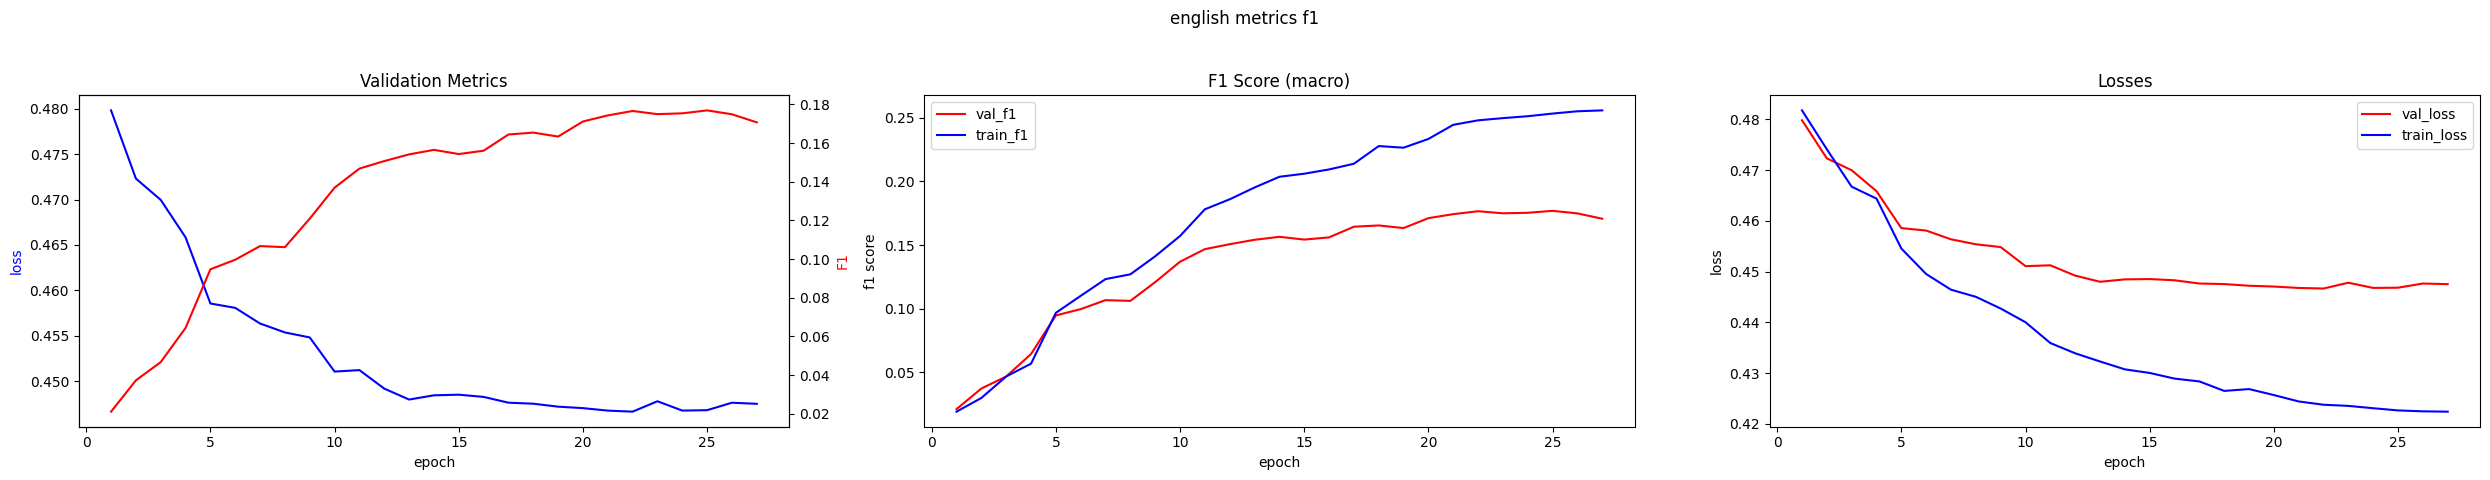

In [6]:
name = train_file_name.split(".")[0]
if print_graphs:
    file_name=data_path.split("/")[-1].split(".")[0]
    title=f"{file_name} metrics accuracy"
    print_results(train_acc, train_loss, val_acc, val_loss, results_path, title, extra_save = f"_{name}")
    title=f"{file_name} metrics f1"
    print_results_f1(train_f1, train_loss, val_f1, val_loss, results_path, title, extra_save = f"_{name}")

In [ ]:
print("Saving model...")
save_path = os.path.join(save_model_path, f"torchmodel_weights_{name}.pth")
torch.save(model.state_dict(), save_path)


Saving model...


RuntimeError: ignored